<a href="https://colab.research.google.com/github/HungPham2002/vae/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=256, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.ToTensor()),
    batch_size=256, shuffle=False)

In [4]:
class VAE(nn.Module):
  def __init__(self, d=64):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784, d*8),
        nn.ReLU(),
        nn.Linear(d*8, d*4),
        nn.ReLU(),
        nn.Linear(d*4,d*2)
    )

    self.decoder = nn.Sequential(
        nn.Sequential(
            nn.Linear(d, d*4),
            nn.ReLU(),
            nn.Linear(d*4,d*8),
            nn.ReLU(),
            nn.Linear(d*8,784),
            nn.Sigmoid()
        )
    )
    self.d = d

  def reparameterise(self, mu, logvar):
    if self.training:
        std = logvar.mul(0.5).exp_()
        epsilon = std.data.new(std.size()).normal_()
        return epsilon.mul(std).add_(mu)
    else:
        return mu

  def forward(self, x):
    mu_logvar = self.encoder(x.view(-1,784)).view(-1,2,self.d)
    mu = mu_logvar[:,0,:]
    logvar = mu_logvar[:,1,:]
    z = self.reparameterise(mu, logvar)
    return self.decoder(z), mu, logvar

In [5]:
model = VAE().to(device)
model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
)

In [6]:
def loss_function(x_hat, x, mu, logvar, beta=1):
    bce = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return bce + beta * KLD

optimizer = optim.Adam(model.parameters(), lr=1e-3)

100%|██████████| 235/235 [00:15<00:00, 15.40it/s]


Epoch 1, Loss: 203.21109091796876


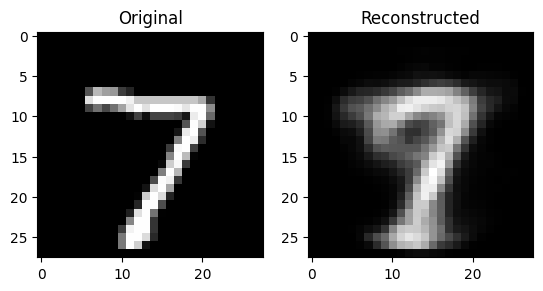

100%|██████████| 235/235 [00:07<00:00, 29.71it/s]


Epoch 2, Loss: 152.25541095377605


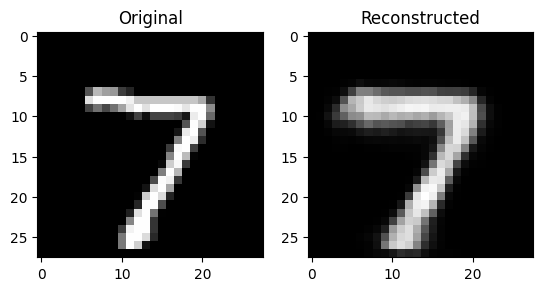

100%|██████████| 235/235 [00:07<00:00, 32.34it/s]


Epoch 3, Loss: 133.78739361979166


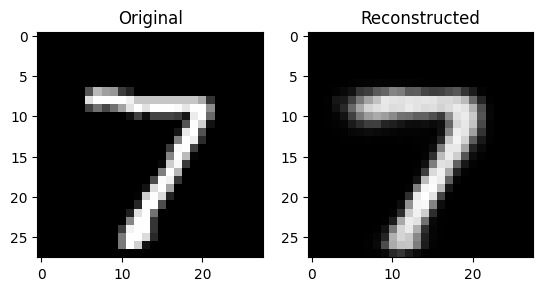

100%|██████████| 235/235 [00:07<00:00, 30.14it/s]


Epoch 4, Loss: 123.6100720703125


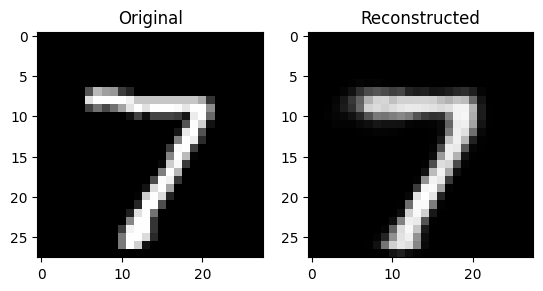

100%|██████████| 235/235 [00:07<00:00, 30.15it/s]


Epoch 5, Loss: 117.67057439778645


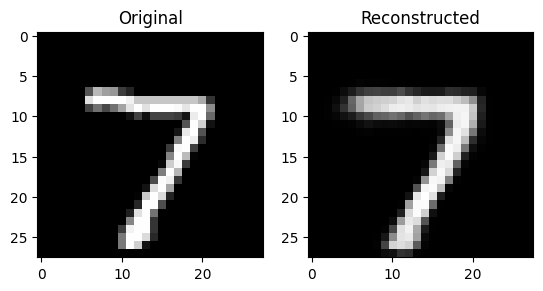

100%|██████████| 235/235 [00:07<00:00, 32.38it/s]


Epoch 6, Loss: 114.07505691731771


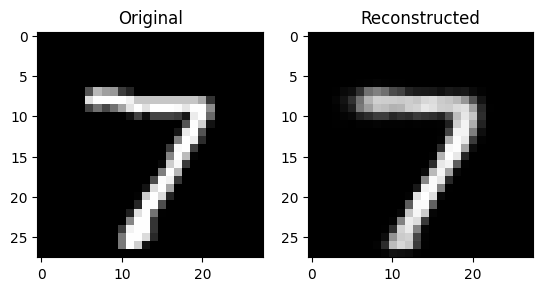

100%|██████████| 235/235 [00:07<00:00, 29.50it/s]


Epoch 7, Loss: 111.80687179361979


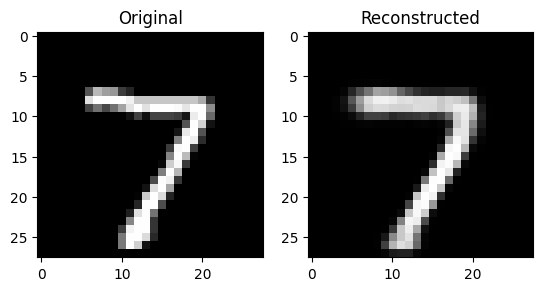

100%|██████████| 235/235 [00:08<00:00, 28.24it/s]


Epoch 8, Loss: 109.9538702311198


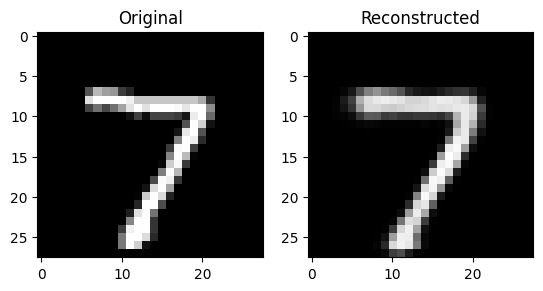

100%|██████████| 235/235 [00:07<00:00, 32.28it/s]


Epoch 9, Loss: 108.50071759440104


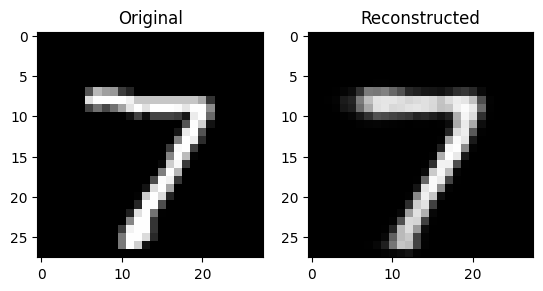

100%|██████████| 235/235 [00:08<00:00, 28.95it/s]


Epoch 10, Loss: 107.09906966145833


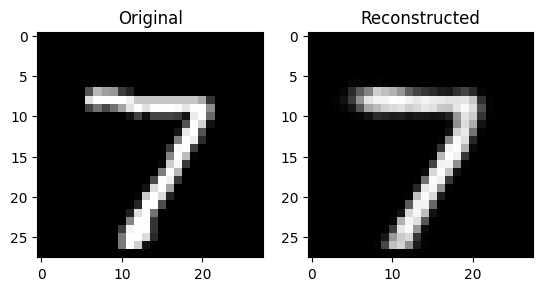

100%|██████████| 235/235 [00:07<00:00, 29.62it/s]


Epoch 11, Loss: 105.98586310221354


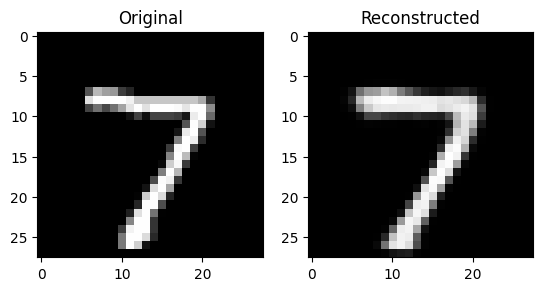

100%|██████████| 235/235 [00:08<00:00, 27.71it/s]


Epoch 12, Loss: 105.07040428059896


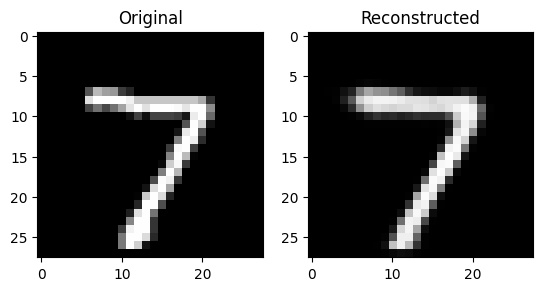

100%|██████████| 235/235 [00:07<00:00, 30.77it/s]


Epoch 13, Loss: 104.45800854492188


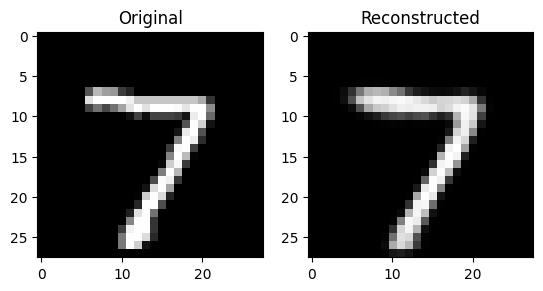

100%|██████████| 235/235 [00:08<00:00, 29.03it/s]


Epoch 14, Loss: 103.81732765299479


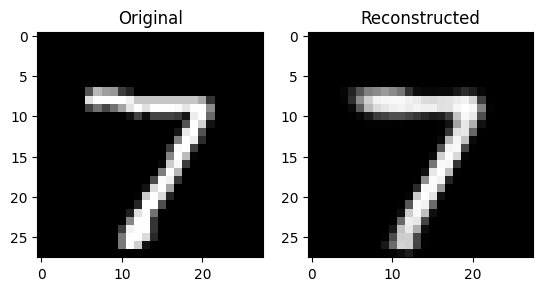

100%|██████████| 235/235 [00:07<00:00, 31.82it/s]


Epoch 15, Loss: 103.23420289713542


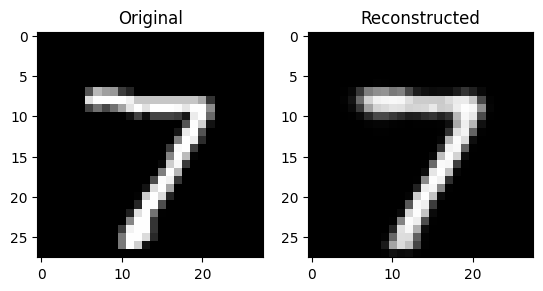

100%|██████████| 235/235 [00:07<00:00, 30.47it/s]


Epoch 16, Loss: 102.82173665364583


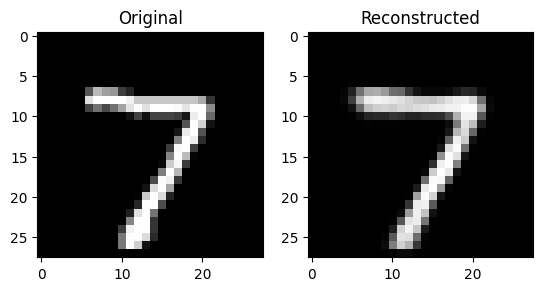

100%|██████████| 235/235 [00:08<00:00, 27.51it/s]


Epoch 17, Loss: 102.40813580729167


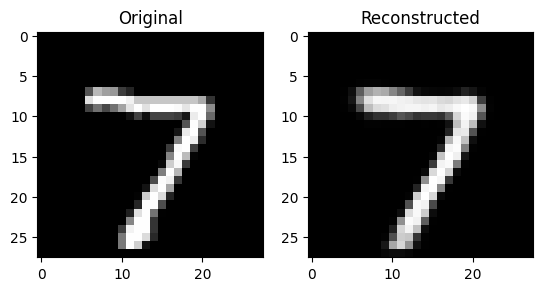

100%|██████████| 235/235 [00:14<00:00, 16.29it/s]


Epoch 18, Loss: 101.9850453125


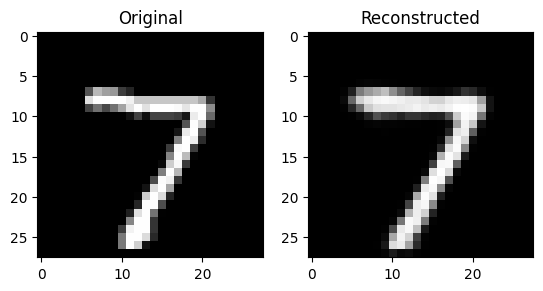

100%|██████████| 235/235 [00:08<00:00, 29.18it/s]


Epoch 19, Loss: 101.59855385742188


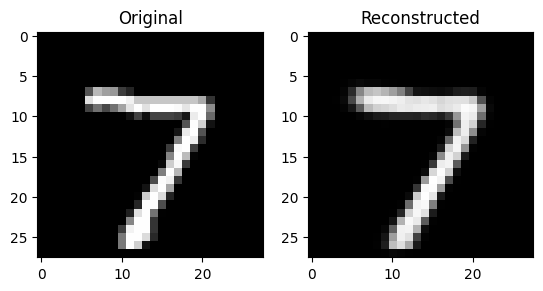

100%|██████████| 235/235 [00:07<00:00, 32.35it/s]


Epoch 20, Loss: 101.2352177734375


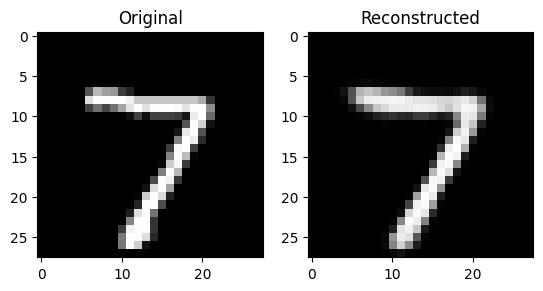

In [7]:
num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    average_loss = train_loss / len(train_loader.dataset)
    train_losses.append(average_loss)
    print(f'Epoch {epoch + 1}, Loss: {average_loss}')

    # Plotting original and reconstructed images
    with torch.no_grad():
        model.eval()
        data = next(iter(val_loader))[0].to(device)
        recon_batch, _, _ = model(data)
        recon_batch = recon_batch.view(-1, 1, 28, 28)
        data = data.cpu().numpy()
        recon_batch = recon_batch.cpu().numpy()

        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(data[0].reshape(28, 28), cmap='gray')
        axes[0].set_title('Original')
        axes[1].imshow(recon_batch[0].reshape(28, 28), cmap='gray')
        axes[1].set_title('Reconstructed')
        plt.show()

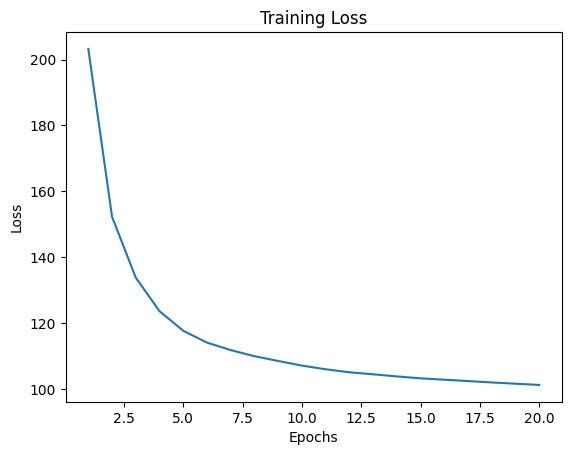

In [8]:

# Plot the training loss
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

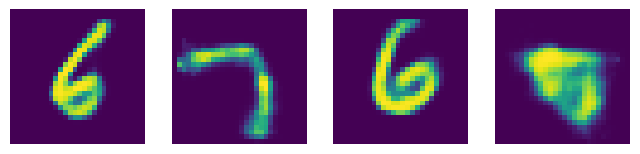

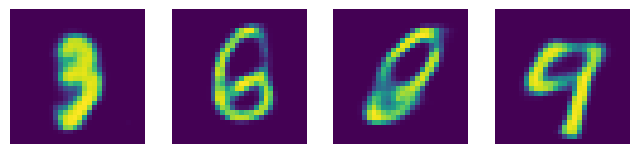

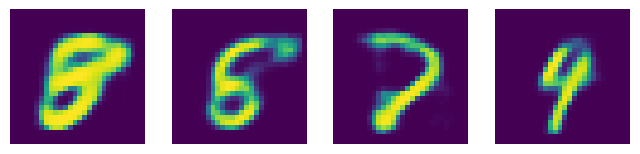

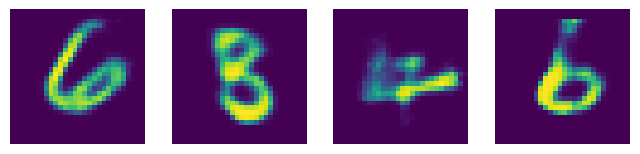

In [12]:
def display_images(out, n=1):
    for N in range(n):
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(8, 4))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
N = 16
d = 64
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(sample, N // 4)